In [ ]:
# Installazione delle dipendenze
!pip install stable-baselines3[extra] gymnasium pygame pyvirtualdisplay
!apt-get install -y xvfb
!pip install pyvirtualdisplay

# Import delle librerie
from pyvirtualdisplay import Display
import numpy as np
import gymnasium as gym
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import DummyVecEnv
from stable_baselines3.common.vec_env import VecNormalize
import pyvirtualdisplay
import cv2
from IPython.display import display, Image

# Avvia display virtuale
display = Display(visible=0, size=(1920, 1080))
display.start()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
class MouseEnv(gym.Env):
    def __init__(self):
        super(MouseEnv, self).__init__()
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(2,), dtype=np.float32)
        self.action_space = gym.spaces.Box(low=-10, high=10, shape=(2,), dtype=np.float32)

        self.cursor = np.array([960, 540], dtype=np.float32)  # Inizia al centro della schermata
        self.target = np.random.randint(0, [1920, 1080])  # Target randomico
        self.max_steps = 500
        self.steps = 0

    def reset(self, seed=None, options=None):
        self.steps = 0
        self.cursor = np.array([960, 540], dtype=np.float32)  # Reset cursore al centro
        self.target = np.random.randint(0, [1920, 1080])
        return self.cursor / np.array([1920, 1080]), {}  # Spazio normalizzato

    def step(self, action):
        self.steps += 1
        dx, dy = action

        # Distanza orizzontale tra cursore e target
        distance_to_target_x = self.target[0] - self.cursor[0]
        distance_to_target_y = self.target[1] - self.cursor[1]

        # Velocità orizzontale in base alla distanza
        max_speed = 20
        speed_x = min(max_speed, abs(distance_to_target_x) / 10)
        speed_y = np.random.randn() * 5

        # Direzione movimento in base a posizione del target
        if distance_to_target_x > 0:
            dx = min(speed_x, distance_to_target_x)
        else:
            dx = max(-speed_x, distance_to_target_x)

        prev_distance = np.linalg.norm(self.cursor - self.target)
        # Muove il cursore
        self.cursor = np.clip(self.cursor + np.array([dx, dy], dtype=np.float32), [0, 0], [1920, 1080])

        # Distanza dal target
        distance = np.linalg.norm(self.cursor - self.target)

        # Più vicino al target, maggiore è la ricompensa
        reward = (prev_distance - distance) * 10

        # Piccola ricompensa se la distanza è diminuita
        if distance < 10:
            reward += 100

        reward -= 0.01  # Penalità per ogni passo

        # Condizione di fine (target raggiunto o massimo numero di passi)
        done = distance < 10 or self.steps >= self.max_steps
        return self.cursor / np.array([1920, 1080]), reward, done, False, {}

In [ ]:
from stable_baselines3.common.callbacks import BaseCallback

class RewardLoggerCallback(BaseCallback):
    def __init__(self, check_freq, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.rewards = []

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            mean_reward = np.mean(self.locals["rewards"])
            self.rewards.append(mean_reward)
        return True

callback = RewardLoggerCallback(check_freq=1000)

In [ ]:
# Creazione dell'ambiente
env = DummyVecEnv([lambda: MouseEnv()])
env = VecNormalize(env, norm_reward=True, gamma=0.99)

# Configurazione del modello PPO
policy_kwargs = dict(
    net_arch=[256, 256],
    activation_fn=torch.nn.ReLU
)

# Modello PPO
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    batch_size=64,
    n_steps=4096,
    learning_rate=0.0001,
    ent_coef=0.0005,
    gae_lambda=0.95,
    policy_kwargs=policy_kwargs,
    tensorboard_log="logs/",
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# Addestramento del modello
model.learn(total_timesteps=200000, callback=callback)

# Salvataggio del modello
model.save("mouse_movement_model.zip")

# Download del modello
from google.colab import files
files.download("mouse_movement_model.zip")

Using cpu device
Logging to logs/PPO_6
-----------------------------
| time/              |      |
|    fps             | 894  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 4096 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 615         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010560212 |
|    clip_fraction        | 0.0829      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.00229    |
|    learning_rate        | 0.0001      |
|    loss                 | 0.0511      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00694    |
|    std                  | 0.999       |
|    value_loss           | 0.875    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

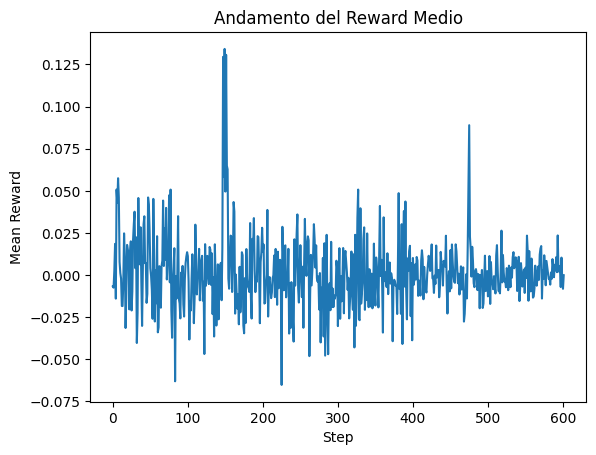

In [ ]:
import matplotlib.pyplot as plt

plt.plot(callback.rewards)
plt.xlabel("Step")
plt.ylabel("Mean Reward")
plt.title("Andamento del Reward Medio")
plt.show()